In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr, linregress

In [52]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
# proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038']

da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='kde_af')
da.load_results_da()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


5041.1127765100155 3016.77983666189 5502.113555955339
0.0 25.216 24.93199999999999


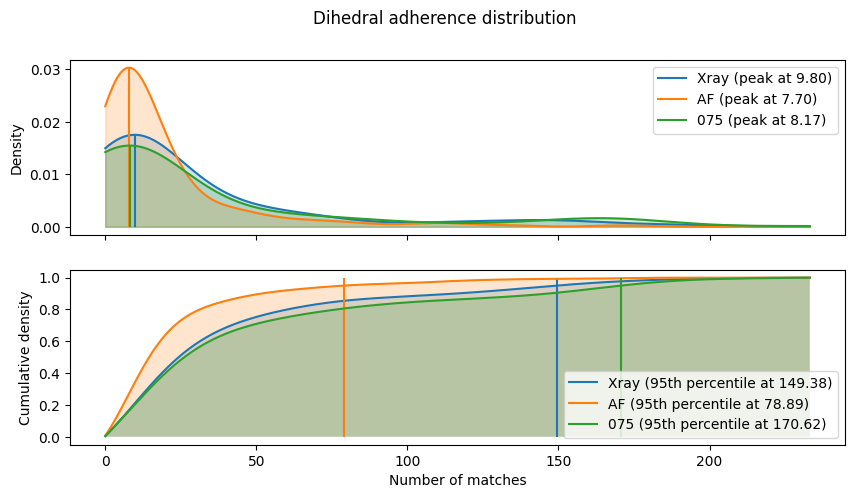

In [150]:
from scipy.stats import gaussian_kde

xray_phi_psi = da.xray_phi_psi.dropna().copy()
af_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == da.alphafold_id].dropna().copy()
results = da.grouped_preds.set_index('protein_id')
xray_phi_psi['rmsd'] = 0
af_phi_psi['rmsd'] = results.loc[da.alphafold_id].RMS_CA

other_id = da.protein_ids[0]
other_phi_psi = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == other_id].dropna().copy()
other_phi_psi['rmsd'] = results.loc[other_id].RMS_CA

print(xray_phi_psi.da.sum(), af_phi_psi.da.sum(), other_phi_psi.da.sum())
print(xray_phi_psi.rmsd.mean(), af_phi_psi.rmsd.mean(), other_phi_psi.rmsd.mean())

df = pd.concat([
    xray_phi_psi, 
    af_phi_psi.drop('da_na', axis=1),
    other_phi_psi.drop('da_na', axis=1)
])

def get_probs(x, da):
    kde = gaussian_kde(da)
    p = kde(x)
    c = np.cumsum(p) / np.sum(p)
    peak = x[np.argmax(p)]
    return p, c, peak

fig, axes = plt.subplots(2, sharex=True, figsize=(10, 5))
x = np.linspace(0, df.da.max(), 1000)

def plot(df, label, color):
    p, c, peak = get_probs(x, df.da)
    axes[0].plot(x, p, color=color, label=f'{label} (peak at {peak:.2f})')
    axes[0].fill_between(x, 0, p, alpha=0.2, color=color)
    axes[0].vlines(peak, 0, p.max(), color=color)
    perc = x[np.argmax(c > 0.95)]
    axes[1].plot(x, c, color=color, label=f'{label} (95th percentile at {perc:.2f})')
    axes[1].vlines(perc, 0, 1, color=color)
    axes[1].fill_between(x, 0, c, alpha=0.2)

colors = sns.color_palette("tab10")
plot(xray_phi_psi, 'Xray', colors[0])
plot(af_phi_psi, 'AF', colors[1])
plot(other_phi_psi, other_id[7:10], colors[2])
axes[0].legend()
axes[0].set_ylabel('Density')
axes[1].legend(loc='lower right')
axes[1].set_xlabel('Number of matches')
axes[1].set_ylabel('Cumulative density')
# axes[0].set_xlim(0, 5000)
# axes[1].set_xlim(0, 5000)
fig.suptitle('Dihedral adherence distribution')
plt.show()

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Slope: -59.309011884314515, Intercept: 128.7485419646507 R-squared: 0.5465181030325024


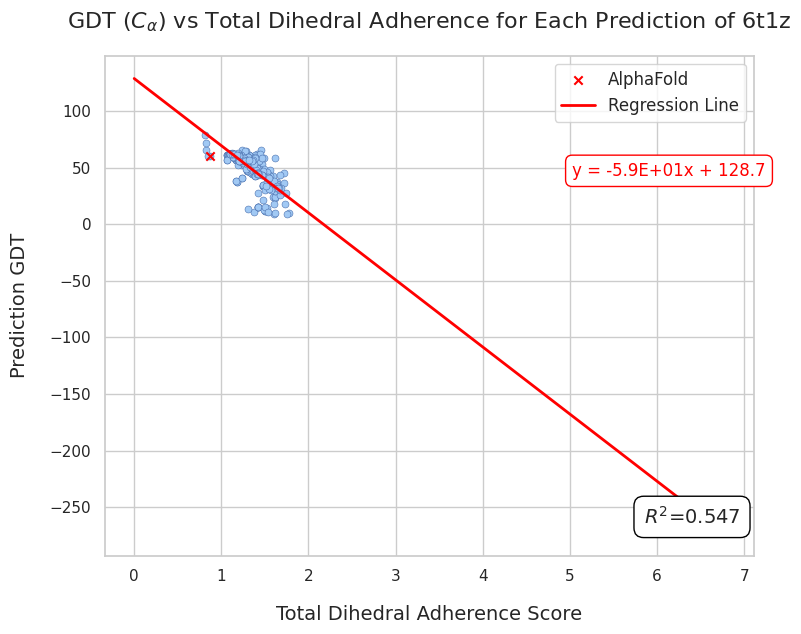

In [33]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']

da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                       mode='ml', weights_file='ml_data/best_model-kde_16-32_383.pt', device='cuda')
da.load_results_da()
da.filter_nas(0.8)
da.grouped_preds['da'] = np.log10(da.grouped_preds.da)
da.plot_da_vs_gdt_simple()

In [30]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
t0 = 1.25
n = 4
# thresholds = np.array([t0 * (i+1) for i in range(n)])
thresholds = np.array([t0 + 0.25 * (i) for i in range(n)])
print(thresholds)
scores = []
gdts = []
pred_ids = []
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                    mode='ml', weights_file='ml_data/best_model-kde_16-32_383.pt', device='cuda')
da.load_results_da()
da.filter_nas(0.8)
da.phi_psi_predictions['da'] = np.log10(da.phi_psi_predictions.da)
for id in da.protein_ids:
    pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
    if pred.shape[0] == 0:
        continue
    gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
    if len(gdt) == 0:
        continue
    gdt = gdt[0]
    score = [(pred.da < thresholds[0]).sum() / pred.shape[0]]
    for i in range(1, n):
        # score.append(((pred.da > thresholds[i-1]) & (pred.da < thresholds[i])).sum() / pred.shape[0])
        score.append(((pred.da < thresholds[i])).sum() / pred.shape[0])
    scores.append(np.mean(score))
    gdts.append(gdt)
    pred_ids.append(id)
das = pd.DataFrame({'protein_id': pred_ids, 'gdt': gdts, 'score': scores})

[1.25 1.5  1.75 2.  ]
Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


0.5082432926003615 PearsonRResult(statistic=0.7129118406930562, pvalue=7.599878170117197e-61)
Slope: 132.34585465313933, Intercept: -61.85943126065013


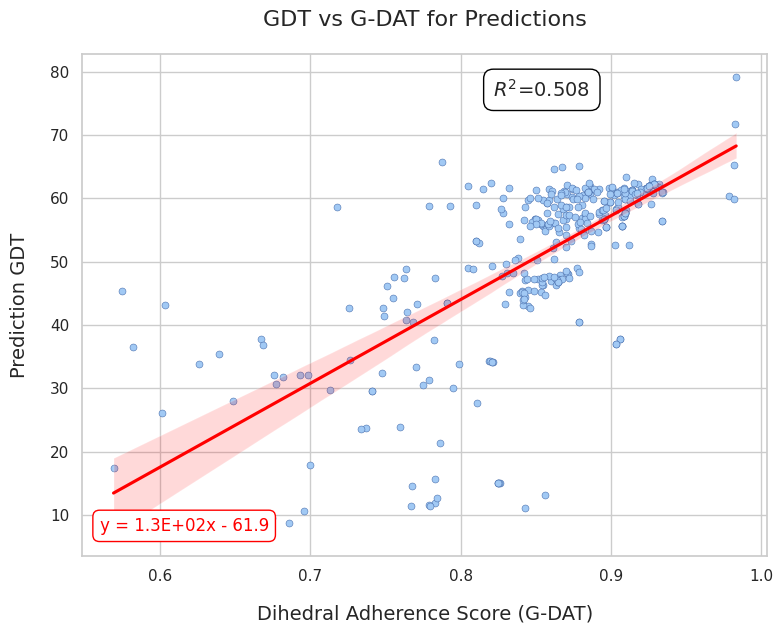

In [31]:
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
das = das.dropna(subset=['score', 'gdt']).reset_index(drop=True)
# df = df[df.GDT_TS < 20]
regr = linregress(das.score, das.gdt)
corr = pearsonr(das['score'], das['gdt'])
print(regr.rvalue**2, corr)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
sns.scatterplot(data=das, x='score', y='gdt', ax=ax, marker='o', s=25, edgecolor='b', legend=True)
sns.regplot(data=das.reset_index(drop=True), x='score', y='gdt', ax=ax, scatter=False, color='red')

ax.set_xlabel('Dihedral Adherence Score (G-DAT)', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction GDT', fontsize=14, labelpad=15)
ax.set_title(r'GDT vs G-DAT for Predictions', fontsize=16, pad=20)
ax.text(0.6, 0.95, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.05, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
# plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
sns.reset_defaults()

# Combined

In [ ]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'

proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2']
results = []
maxt = [32,16,8]
for i,nthresh in enumerate([4,5,6]):
# for nthresh in [2,3]:
    for thresh1 in np.linspace(1, maxt[i], maxt[i]).round(2):
    # for thresh1 in np.linspace(1, 64, 64).round(2):
        thresholds = np.array([thresh1 * 2**i for i in range(nthresh)])
        scores = []
        gdts = []
        protein_ids = []
        for protein in proteins:
            da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                                mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
            da.load_results_da()
            da.filter_nas(0.8)
            pbar = tqdm(da.protein_ids)
            pbar.set_description(f'Nthresh {nthresh} Protein {protein} Initial Threshold {thresh1}')

            for id in pbar:
                pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
                if pred.shape[0] == 0:
                    continue
                gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
                if len(gdt) == 0:
                    continue
                gdt = gdt[0]
                score = np.mean([(pred.da < thresh).sum() / pred.shape[0] for thresh in thresholds])
                scores.append(score)
                gdts.append(gdt)
                protein_ids.append(protein)
                pred_ids.append(id)
            
        model = stats.linregress(gdts, scores)
        results.append((nthresh, thresh1, model.slope, model.intercept, model.rvalue**2, model.pvalue))
        results_df = pd.DataFrame(results, columns=['nthresh', 'initial_threshold', 'slope', 'intercept', 'rsquared', 'pvalue'])
        results_df.to_csv('results_threshold_combined2.csv', index=False)

In [225]:
df = pd.read_csv('results_threshold_combined2.csv')
df.sort_values('rsquared', ascending=False).head(5)

,nthresh,initial_threshold,slope,intercept,rsquared,pvalue
103,3,40.0,0.005856,0.606763,0.529425,0.0
105,3,42.0,0.005575,0.628165,0.529379,0.0
98,3,35.0,0.006534,0.555578,0.529338,0.0
104,3,41.0,0.005720,0.617352,0.529245,0.0
101,3,38.0,0.006141,0.585450,0.529080,0.0


In [301]:
np.linspace(1,256,16)[1:-1]

array([ 18.,  35.,  52.,  69.,  86., 103., 120., 137., 154., 171., 188.,
       205., 222., 239.])

In [323]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
# t0 = 40.0
n = 4
# thresholds = np.array([t0 * 2**i for i in range(n)])
thresholds = np.linspace(1,256,16)[1:-1]#[16, 96, 136, 216]
scores = []
gdts = []
protein_ids = []
pred_ids = []
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                        mode='ml', weights_file='ml_data/best_model-kde_16-32_383.pt', device='cuda')
    da.load_results_da()
    da.filter_nas(0.8)
    pbar = tqdm(da.protein_ids)
    pbar.set_description(f'Protein {protein}')
    for id in pbar:
        pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
        if pred.shape[0] == 0:
            continue
        gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
        if len(gdt) == 0:
            continue
        gdt = gdt[0]
        score = [(pred.da < thresholds[0]).sum() / pred.shape[0]]
        for i in range(1, n):
            score.append(((pred.da > thresholds[i-1]) & (pred.da < thresholds[i])).sum() / pred.shape[0])
            # score.append((pred.da < thresholds[i]).sum() / pred.shape[0])
        # model = pickle.load(open('model_thresholds.pkl', 'rb'))
        # scores.append(model.predict(np.array([1]+score).reshape(1,-1))[0])
        # score = np.mean([(pred.da < thresh).sum() / pred.shape[0] for thresh in thresholds])
        scores.append(score)
        gdts.append(gdt)
        protein_ids.append(protein)
        pred_ids.append(id)
das = pd.DataFrame({'protein': protein_ids, 'gdt': gdts, 'score': scores, 'pred_id': pred_ids})

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 


Protein T1024: 100%|██████████| 478/478 [00:03<00:00, 154.88it/s]


Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No AlphaFold prediction found for 7um1
No AlphaFold phi-psi data found


Protein T1096: 100%|██████████| 430/430 [00:02<00:00, 146.23it/s]


Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found


Protein T1091: 100%|██████████| 384/384 [00:04<00:00, 84.01it/s]


Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


Protein T1030: 100%|██████████| 462/462 [00:02<00:00, 230.75it/s]


Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No AlphaFold prediction found for 6ya2
No AlphaFold phi-psi data found


Protein T1038: 100%|██████████| 467/467 [00:01<00:00, 269.33it/s]


Initializing T1030-D2 ...
Results already exist
Casp ID: T1030-D2 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No CASP AlphaFold prediction


Protein T1030-D2: 100%|██████████| 491/491 [00:01<00:00, 457.06it/s]


Initializing T1024-D1 ...
Results already exist
Casp ID: T1024-D1 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
No CASP AlphaFold prediction


Protein T1024-D1: 100%|██████████| 506/506 [00:01<00:00, 291.68it/s]


Initializing T1032-D1 ...
Results already exist
Casp ID: T1032-D1 	PDB: 6n64
Structure exists: 'pdb/pdb6n64.ent' 
No CASP AlphaFold prediction


Protein T1032-D1: 100%|██████████| 562/562 [00:02<00:00, 269.35it/s]


Initializing T1053-D1 ...
Results already exist
Casp ID: T1053-D1 	PDB: 7m7a
Structure exists: 'pdb/pdb7m7a.ent' 
No CASP AlphaFold prediction


Protein T1053-D1: 100%|██████████| 488/488 [00:03<00:00, 156.76it/s]


Initializing T1027-D1 ...
Results already exist
Casp ID: T1027-D1 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 
No CASP AlphaFold prediction


Protein T1027-D1: 100%|██████████| 521/521 [00:01<00:00, 481.37it/s]


Initializing T1029-D1 ...
Results already exist
Casp ID: T1029-D1 	PDB: 6uf2
Structure exists: 'pdb/pdb6uf2.ent' 
No CASP AlphaFold prediction


Protein T1029-D1: 100%|██████████| 497/497 [00:01<00:00, 425.13it/s]


In [397]:
from sklearn.ensemble import RandomForestRegressor

train_ids, test_ids = train_test_split(das.protein.unique(), test_size=0.75)
Xtrain = np.array(das[das.protein.isin(train_ids)].score.tolist())
ytrain = das[das.protein.isin(train_ids)].gdt.values
Xtest = np.array(das[das.protein.isin(test_ids)].score.tolist())
ytest = das[das.protein.isin(test_ids)].gdt.values
model = RandomForestRegressor(n_estimators=10, max_depth=3)
model.fit(Xtrain, ytrain)
print(model.score(Xtrain, ytrain))

print(model.score(Xtest, ytest))

0.7287274882767304
-0.7871839004666628


In [273]:
X = np.array(list(das['score'].values))
y = das['gdt'].values
X = sm.add_constant(X)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
model = sm.OLS(ytrain, Xtrain).fit()
print(model.summary())

y_pred = model.predict(Xtest)
print(r2_score(ytest, y_pred))

model = sm.OLS(y, X).fit()
das['gdt_pred'] = model.predict(X)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     717.2
Date:                Mon, 15 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:21:25   Log-Likelihood:                -13818.
No. Observations:                3432   AIC:                         2.765e+04
Df Residuals:                    3427   BIC:                         2.768e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.9618     41.063      5.016      0.0

0.4621450613084091 PearsonRResult(statistic=0.6798125192348325, pvalue=0.0)
Slope: 0.9999999999999982, Intercept: -1.4637180356658064e-12


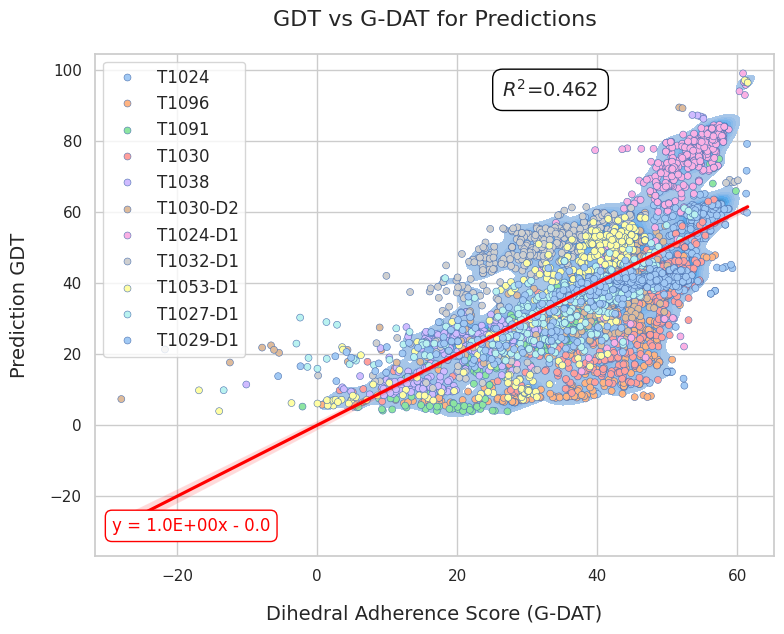

In [208]:
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
das = das.dropna(subset=['gdt_pred', 'gdt']).reset_index(drop=True)
# df = df[df.GDT_TS < 20]
regr = linregress(das.gdt_pred, das.gdt)
corr = pearsonr(das['gdt_pred'], das['gdt'])
print(regr.rvalue**2, corr)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
sns.kdeplot(data=das, x='gdt_pred', y='gdt', ax=ax, fill=True, bw_method=0.1)
sns.scatterplot(data=das, x='gdt_pred', y='gdt', ax=ax, marker='o', s=25, edgecolor='b', legend=True, hue='protein', palette='pastel')
sns.regplot(data=das.reset_index(drop=True), x='gdt_pred', y='gdt', ax=ax, scatter=False, color='red')

ax.set_xlabel('Dihedral Adherence Score (G-DAT)', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction GDT', fontsize=14, labelpad=15)
ax.set_title(r'GDT vs G-DAT for Predictions', fontsize=16, pad=20)
ax.text(0.6, 0.95, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.05, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
sns.reset_defaults()

In [254]:
thresholds

array([ 40.,  80., 160.])

In [253]:
das

,protein,gdt,score,pred_id
0,T1024,59.08,0.965070,T1024TS379_4
1,T1024,60.49,0.957998,T1024TS362_1
2,T1024,34.34,0.870420,T1024TS004_5
3,T1024,62.08,0.976765,T1024TS015_2
4,T1024,37.85,0.961573,T1024TS070_5
...,...,...,...,...
4285,T1029-D1,40.00,0.899160,T1029TS125_1-D1
4286,T1029-D1,34.20,0.773109,T1029TS138_3-D1
4287,T1029-D1,27.40,0.649860,T1029TS437_2-D1
4288,T1029-D1,19.00,0.675070,T1029TS196_1-D1


In [257]:
results = []
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
total_samples = 0
for protein in proteins:
    df = das[das.protein == protein]
    n_preds = df.shape[0]
    total_samples += n_preds
    regr = linregress(df.score, df.gdt)
    rsquared = regr.rvalue**2
    corr = pearsonr(df.score, df.gdt)[0]
    results.append((protein, rsquared, corr, n_preds))
results = pd.DataFrame(results, columns=['protein', 'rsquared', 'pearsonr', 'n_preds'])
results.loc[len(results)] = ['Mean', results.rsquared.mean(), results.pearsonr.mean(), results.n_preds.mean()]
print(total_samples)
results.to_markdown('thisresult.md',index=False)

4290


# Fit linregr from percents to GDT

In [118]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']

import itertools
# for n in range(1,6):
for n in range(3,6):
    results = []
    combinations = list(itertools.combinations(np.linspace(16,256,7), n))
    for thresholds in combinations:
        gdts = []
        scores = []
        for j,protein in enumerate(proteins):
            da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                                mode='ml', weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda')
            da.load_results_da()
            da.filter_nas(0.8)
            for id in da.protein_ids:
                pred = da.phi_psi_predictions[da.phi_psi_predictions.protein_id == id].dropna()
                if pred.shape[0] == 0:
                    continue
                gdt = da.grouped_preds[da.grouped_preds.protein_id == id].GDT_TS.values
                if len(gdt) == 0:
                    continue
                gdt = gdt[0]
                score = [(pred.da < thresholds[0]).sum() / pred.shape[0]]
                for i in range(1, n):
                    score.append(((pred.da > thresholds[i-1]) & (pred.da < thresholds[i])).sum() / pred.shape[0])
                scores.append(score)
                gdts.append(gdt)
        x = np.array(scores)
        y = np.array(gdts)
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        results.append([thresholds, model.rsquared])
        results_df = pd.DataFrame(results, columns=['thresholds', 'rsquared'])
        results_df.to_csv(f'results_threshold_{n}.csv', index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No AlphaFold prediction found for 7um1
No AlphaFold phi-psi data found
Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No AlphaFold prediction found for 7um1
No AlphaFold phi-psi data found
Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structu

KeyboardInterrupt: 

In [48]:
results
X = results.drop(['protein', 'pred_id', 'gdt'], axis=1)
y = results.gdt

import statsmodels.api as sm

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdt   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     1164.
Date:                Mon, 15 Jul 2024   Prob (F-statistic):               0.00
Time:                        11:16:22   Log-Likelihood:                -17307.
No. Observations:                4290   AIC:                         3.462e+04
Df Residuals:                    4286   BIC:                         3.465e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.4101      2.974      5.854      0.000      11.580      23.240
score_t64.0     40.7590      2.980     13.677      0.000      34.916      46.602
score_t128.0   -24.8159      5.704     -4.351      0.000     -35.998     -13.633
score_t192.0   -66.7431      5.478    -12.184      0.000     -77.483     -56.003
score_t256.0    68.2102     13.896      4.909      0.000      40.968      95.453
==============================================================================
Omnibus:                       28.114   Durbin-Watson:                   0.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.473
Skew:                           0.160   Prob(JB):                     1.78e-06
Kurtosis:                       2.786   Cond. No.                     4.80e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.03e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""